## Synthetic dataset generation

We used two steps for simulated data generation. First, we generate the mixed data types using numpy.random module for independent continuous, discrete and categorical and standardize them. We assign weights for features for different predictability (high, medium and low) and generate Bernoulli target variable. Upon conducting the checks on expected distributions and collinearity, we split the dataset into train and test (70/30 proportion). Finally, we apply pyampute to add missing data mechanisms MAR and MCAR with 2 subsets (train and test) at low 10% missing data rate and 2 subsets at high 25% missing data rate.

As a result we got 4 datasets (train and test - low and train and test high), each pair has 1000 data points in total and:

* 25 features 
* 1 binary target  
* Mixed data (15 continuous, 5 discrete, 5 categorical (4 binomial and 1 multinomial nominal at 3 levels))  
* 7 high predictive features ( mixed data types) 
* 9 medium predictive features ( mixed data types)  
* 9 low predictive features (mixed data types) 
* Missing mechanism MAR + MCAR: 1 subset – low rate 10%, 2 subset - higher rate 25%, the proportion is 50/50.  

In [2]:
# libraries 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import scipy.special
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import pyampute
from pyampute import MultivariateAmputation
import os

# reproducibility
RANDOM_SEED = 57
np.random.seed(RANDOM_SEED)


## Step 1: Generate countinious, discrete, categorical distributions.
We use numpy.random module to generate 25 mixed data types variables: normal distribution for 15 countinious variables, as it is default distribution; Poisson distribution for 5 discrete variables; and a mix of 4 binomial and 1 multinomial nominal variable (three levels). 

In [3]:
# generate mixed data - countinious, discrete, categorical
def generate_features(n_samples=1000, random_state=57):
    np.random.seed(random_state)

    # continuous features
    continuous_features = {}
    for i in range(15):
        continuous_features[f'cont_{i}'] = np.random.normal(0, 1, n_samples)
    
    # discrete features
    discrete_features = {}
    lambdas = [2, 3, 4, 5, 6] 
    for i in range(5):
        discrete_features[f'disc_{i}'] = np.random.poisson(lambdas[i], n_samples)

    # categorical features
    categorical_features = {}

    for i in range(5):
        if i < 4:
            # 4 binomial features
            categories = ['Yes', 'No']
            prob = np.random.uniform(0.3, 0.7)  
            probs = [prob, 1-prob]
            categorical_features[f'cat_{i}'] = np.random.choice(categories, size=n_samples, p=probs)
        else: 
            # 1 multinomial feature 
            categories = ['Level_A', 'Level_B', 'Level_C']
            probs = [0.4, 0.35, 0.25]  
            categorical_features[f'cat_{i}'] = np.random.choice(categories, size=n_samples, p=probs)
    
    return continuous_features, discrete_features, categorical_features
    

# generate features
cont_features, disc_features, cat_features = generate_features()

df = pd.DataFrame(cont_features)
for col, values in disc_features.items():
    df[col] = values
for col, values in cat_features.items():
    df[col] = values

print(df.head())



     cont_0    cont_1    cont_2    cont_3    cont_4    cont_5    cont_6  \
0 -0.131052  0.496992  0.812418  0.154248 -1.193735 -0.116268  2.535667   
1 -0.200646 -0.892596 -0.516266  0.192110 -0.247280  1.113102  1.427409   
2 -1.690123 -1.011302  1.722664  0.570576  0.524078 -0.360088 -1.481386   
3 -0.794418 -0.887807 -0.623026 -0.108778 -0.069120  0.913869 -1.426068   
4  1.528002  0.976289  0.806384  0.821523  0.266568  1.411119  0.402828   

     cont_7    cont_8    cont_9  ...  disc_0  disc_1  disc_2  disc_3  disc_4  \
0  0.062346 -1.552921  1.169530  ...       2       4       5       4       6   
1 -0.176624  0.377577 -0.231651  ...       0       4       3       8       5   
2 -2.300283 -0.221106  0.805943  ...       0       1       2       3       3   
3 -0.514799 -0.516567 -0.361832  ...       2       2       5       5       6   
4  0.384616 -1.032995  1.011634  ...       1       0       6       8       6   

   cat_0  cat_1  cat_2  cat_3    cat_4  
0    Yes     No     No     

Next we standardize variables by scaling numerical features ( countinious and discrete) and one-hot encoding the categorical. 

In [4]:
# standardize features
cont_cols = list(cont_features.keys())
disc_cols = list(disc_features.keys())
cat_cols = list(cat_features.keys())

# scale continuous and discrete
scaler = StandardScaler()
df_scaled_cont_disc = pd.DataFrame(
    scaler.fit_transform(df[cont_cols + disc_cols]),
    columns=cont_cols + disc_cols
)

# one-hot encode categorical
encoder = OneHotEncoder(sparse_output=False, drop='first')  
df_encoded_cat = pd.DataFrame(
    encoder.fit_transform(df[cat_cols]),
    columns=encoder.get_feature_names_out(cat_cols)
)
df_encoded_cat = df_encoded_cat.astype(int)

df_processed = pd.concat([df_scaled_cont_disc, df_encoded_cat], axis=1)

print(df_processed.head())


     cont_0    cont_1    cont_2    cont_3    cont_4    cont_5    cont_6  \
0 -0.101021  0.471468  0.797922  0.138696 -1.180801 -0.072553  2.504380   
1 -0.169350 -0.920279 -0.493121  0.176579 -0.237733  1.119136  1.396896   
2 -1.631745 -1.039170  1.682382  0.555259  0.530866 -0.308899 -1.509867   
3 -0.752326 -0.915483 -0.596857 -0.124479 -0.060210  0.926009 -1.454588   
4  1.527867  0.951510  0.792059  0.806348  0.274277  1.408018  0.373031   

     cont_7    cont_8    cont_9  ...    disc_1    disc_2    disc_3    disc_4  \
0  0.063195 -1.662968  1.161105  ...  0.522909  0.512284 -0.453033  0.012989   
1 -0.179877  0.366482 -0.214517  ...  0.522909 -0.473826  1.286058 -0.392932   
2 -2.339990 -0.262888  0.804151  ... -1.163895 -0.966881 -0.887806 -1.204776   
3 -0.523857 -0.573493 -0.342323  ... -0.601627  0.512284 -0.018260  0.012989   
4  0.390997 -1.116393  1.006090  ... -1.726163  1.005339  1.286058  0.012989   

   cat_0_Yes  cat_1_Yes  cat_2_Yes  cat_3_Yes  cat_4_Level_B  cat_4_

Next we assign feature importance with selected weights. We have 7 high, 9 medium and 9 low predictability (importance) features. For each feature importance we select a range of weights randomly assigned within each importance category to create more realistic data.

In [5]:
# assign weights
all_features = df_processed.columns.to_list()

high_importance = ['cont_0', 'cont_3', 'cont_7', 'disc_1', 'disc_3', 'cat_0_Yes', 'cat_2_Yes']  # 7 features
medium_importance = ['cont_1', 'cont_5', 'cont_9', 'cont_11', 'cont_13', 'disc_0', 'disc_4', 'cat_1_Yes', 'cat_4_Level_C']  # 9 features
low_importance = [col for col in all_features if col not in high_importance + medium_importance]  # 9 features 

np.random.seed(57)

# define weight ranges (absolute values)
high_abs_range = (2.0, 3.0)
medium_abs_range = (1.0, 2.0)
low_abs_range = (0.0, 1.0)
    
# assign weights with random signs
feature_weights = {}
for f in high_importance:
    weight = np.random.uniform(*high_abs_range)
    sign = np.random.choice([-1, 1]) 
    feature_weights[f] = np.round(sign * weight, 2)
        
for f in medium_importance:
    weight = np.random.uniform(*medium_abs_range)
    sign = np.random.choice([-1, 1])  
    feature_weights[f] = np.round(sign * weight, 2)
        
for f in low_importance:
    weight = np.random.uniform(*low_abs_range)
    sign = np.random.choice([-1, 1])  
    feature_weights[f] = np.round(sign * weight, 2)

for feature in all_features:
    print(f"{feature}: {feature_weights[feature]}")

cont_0: 2.09
cont_1: -1.64
cont_2: -0.4
cont_3: -2.66
cont_4: -0.12
cont_5: 1.42
cont_6: 0.72
cont_7: -2.31
cont_8: -0.21
cont_9: -1.25
cont_10: -0.08
cont_11: -1.45
cont_12: -0.0
cont_13: -1.84
cont_14: 0.02
disc_0: -1.93
disc_1: 2.81
disc_2: -0.2
disc_3: 2.81
disc_4: 1.49
cat_0_Yes: -2.45
cat_1_Yes: 1.05
cat_2_Yes: -2.42
cat_3_Yes: -0.67
cat_4_Level_B: 0.91
cat_4_Level_C: -1.43


We generate the target variable y_i ~ Bernoulli(p_i) with logit(p_i)=XtB. X is the feature values and B is their weights (importance), that initially resulted in a very unbalanced distribution of target variable ( skewed towards positive class). To make our dataset more balanced, we added the intercept term. First we searched for the intercept value with "y" mean closest to 0.5 (hence balanced). Then we apply the intercept value, in this case equal to 4 to generate target variable. 

In [6]:
# generate target variable
X = df_processed[all_features].values
B = np.array([feature_weights[f] for f in all_features])

results = []
# search for intercept balancing the target variable
for intercept in [1,2,3,4,5]:
    logit_p = X @ B + intercept
    p = scipy.special.expit(logit_p)
    y = np.random.binomial(1, p)
    results.append((intercept, y.mean()))

print(results)

# generate target with chosen intercept
my_intercept = 4
logit_p = X @ B + my_intercept
p = scipy.special.expit(logit_p)
y = np.random.binomial(1, p)
df_processed['target'] = y

print(df_processed.head())

synthetic_data = df_processed.copy()


[(1, 0.378), (2, 0.405), (3, 0.473), (4, 0.529), (5, 0.574)]
     cont_0    cont_1    cont_2    cont_3    cont_4    cont_5    cont_6  \
0 -0.101021  0.471468  0.797922  0.138696 -1.180801 -0.072553  2.504380   
1 -0.169350 -0.920279 -0.493121  0.176579 -0.237733  1.119136  1.396896   
2 -1.631745 -1.039170  1.682382  0.555259  0.530866 -0.308899 -1.509867   
3 -0.752326 -0.915483 -0.596857 -0.124479 -0.060210  0.926009 -1.454588   
4  1.527867  0.951510  0.792059  0.806348  0.274277  1.408018  0.373031   

     cont_7    cont_8    cont_9  ...    disc_2    disc_3    disc_4  cat_0_Yes  \
0  0.063195 -1.662968  1.161105  ...  0.512284 -0.453033  0.012989          1   
1 -0.179877  0.366482 -0.214517  ... -0.473826  1.286058 -0.392932          0   
2 -2.339990 -0.262888  0.804151  ... -0.966881 -0.887806 -1.204776          0   
3 -0.523857 -0.573493 -0.342323  ...  0.512284 -0.018260  0.012989          1   
4  0.390997 -1.116393  1.006090  ...  1.005339  1.286058  0.012989          1   

 

Checked if generated features have expected data type - categorical are integers since they are encoded, countinious and discrete are floats since they are scaled. 

In [7]:
# check data types
synthetic_data.dtypes

cont_0           float64
cont_1           float64
cont_2           float64
cont_3           float64
cont_4           float64
cont_5           float64
cont_6           float64
cont_7           float64
cont_8           float64
cont_9           float64
cont_10          float64
cont_11          float64
cont_12          float64
cont_13          float64
cont_14          float64
disc_0           float64
disc_1           float64
disc_2           float64
disc_3           float64
disc_4           float64
cat_0_Yes          int64
cat_1_Yes          int64
cat_2_Yes          int64
cat_3_Yes          int64
cat_4_Level_B      int64
cat_4_Level_C      int64
target             int64
dtype: object

Checked distributions - overall numerical have are normally distributed, categorical differently balanced as expected, target - balanced.

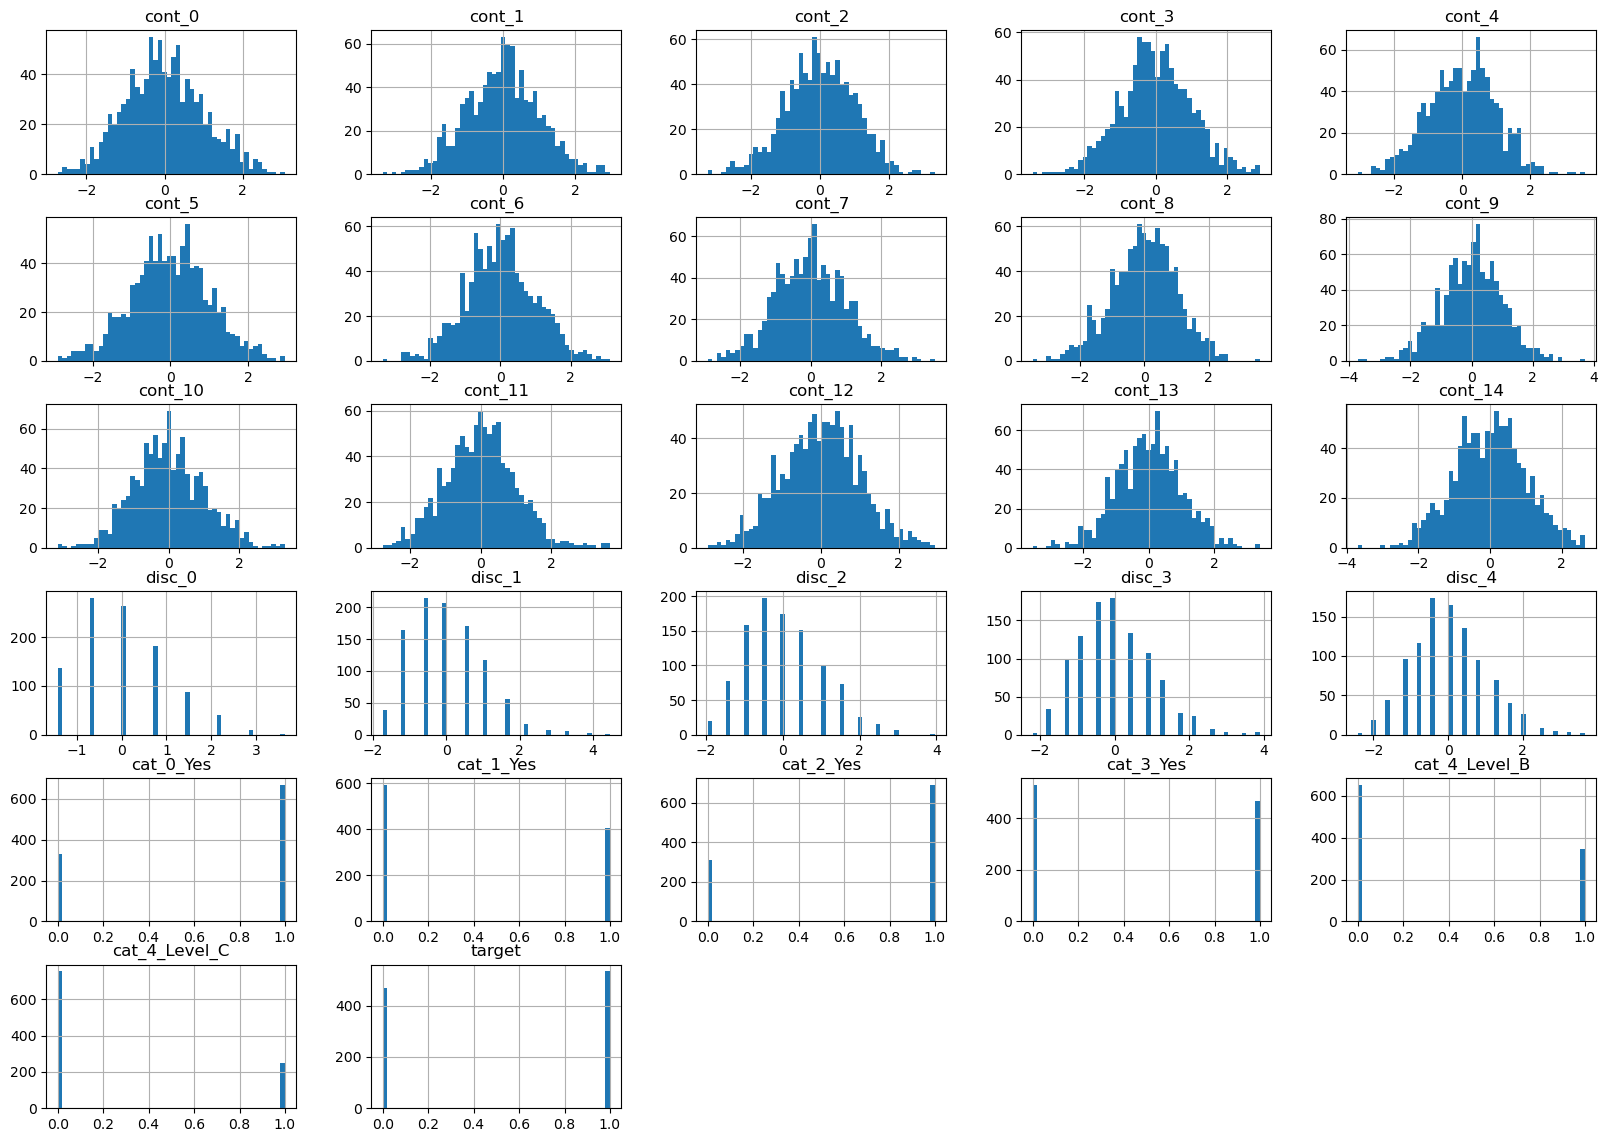

In [8]:
# check distributions
synthetic_data.hist(figsize=(20,14), bins=50)
plt.show()


Checked for collinearity since we want to avoid it, the VIF (variance inflation factor) values are around 1-2, which suggests no collinearity between the variables.

In [34]:
# check collinearity 
X_vif = synthetic_data.drop(columns=['target'])

vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)

          feature       VIF
0          cont_0  1.021046
1          cont_1  1.017865
2          cont_2  1.028398
3          cont_3  1.025213
4          cont_4  1.015497
5          cont_5  1.022538
6          cont_6  1.029529
7          cont_7  1.023168
8          cont_8  1.034761
9          cont_9  1.020401
10        cont_10  1.033675
11        cont_11  1.023194
12        cont_12  1.022787
13        cont_13  1.017093
14        cont_14  1.030675
15         disc_0  1.024323
16         disc_1  1.018521
17         disc_2  1.021735
18         disc_3  1.021159
19         disc_4  1.022141
20      cat_0_Yes  2.198471
21      cat_1_Yes  1.574956
22      cat_2_Yes  2.355252
23      cat_3_Yes  1.761253
24  cat_4_Level_B  1.645020
25  cat_4_Level_C  1.465926


## Step 2: apply MAR and MCAR missing data mechanisms at missing rates low 10% and high 25%. 

First we split the data for training and test sets (proportion 70/30) to avoid data leakage when applying missing data mechanisms. We use stratified split by target variable to ensure both test and train are balanced. 

In [35]:
# train test split
train_data, test_data = train_test_split(synthetic_data, test_size=0.3, random_state=57, stratify=synthetic_data['target'])
print(train_data.shape, test_data.shape)
print(train_data['target'].value_counts())
print(test_data['target'].value_counts())

(700, 27) (300, 27)
target
1    370
0    330
Name: count, dtype: int64
target
1    159
0    141
Name: count, dtype: int64


In [15]:
# save complete datasets
os.makedirs("data/complete", exist_ok=True)

train_data.to_csv("data/complete/train_complete.csv", index=False)
test_data.to_csv("data/complete/test_complete.csv", index=False)

We dublicate sets for 2 missing data mechanisms that we will apply.

In [16]:
# dublicate dataset for 2 missing data mechanisms
train_1 = train_data.copy()
test_1 = test_data.copy()

train_2 = train_data.copy()
test_2 = test_data.copy()

Then we select features for MAR and MCAR mechanism amputation, except for target variable. We create a function that applies missing data mechanism balanced 50/50 MAR and MCAR. Using pyampute library we make the amputation, manually searching for the prop that does required missing data rate 10% for one scenario (train and test) and 25% for another scenario (train and test). 

In [24]:
# apply amputation for missing data mechanisms
features = [col for col in train_1.columns if col != 'target']

# features for MCAR and MAR amputation
mcar_features = ['cont_0', 'cont_1', 'cont_2','disc_2','disc_4','cat_0_Yes','cat_3_Yes']  
mar_features = ['cont_3', 'cont_4', 'cont_5', 'disc_0','disc_1','cat_4_Level_B', 'cat_4_Level_C']  

# function for amputation, balanced MCAR and MAR
def apply_amputation(df, mcar_features, mar_features, prop, seed=57):
    features = [col for col in df.columns if col != 'target']
    patterns = [
        {
            "incomplete_vars": mcar_features,
            "mechanism": "MCAR",
            "freq": 0.5
        },
        {
            "incomplete_vars": mar_features,
            "mechanism": "MAR",
            "freq": 0.5,
            "weights": {
                "cont_7": 1.5,
                "cont_9": 1.3,
                "cont_11": 1.1,
                "disc_3": 1.0,
            }

        }
    ]
    amputer = MultivariateAmputation(prop=prop, patterns=patterns, seed=seed)
    features_with_missing = amputer.fit_transform(df[features])
    df_miss = df.copy()
    df_miss[features] = features_with_missing

    # dataset results
    print(df_miss.head())
    print(df_miss.isnull().sum().sum())
    total_cells = df_miss.shape[0] * (df_miss.shape[1] - 1)
    missing_rate = (df_miss.drop('target', axis=1).isnull().sum().sum() / total_cells) * 100
    print(f"\nActual missing rate: {missing_rate:.2f}%")
    return df_miss

# apply for train with low 10% missing rate
train_1_low = apply_amputation(train_1, mcar_features, mar_features, prop=0.371, seed=57)


2025-07-17 13:10:55,819 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data/shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2025-07-17 13:10:55,820 [WARNING] Indicated weights for incomplete vars for a pattern with MAR. Did you mean MAR+MNAR?


       cont_0    cont_1    cont_2    cont_3    cont_4    cont_5    cont_6  \
242  0.670806  0.296225 -0.485741 -0.491241  0.519416 -0.779885  1.299805   
896 -0.073831 -1.706362 -0.486604  0.363134 -0.463833 -2.057828 -0.877546   
818  0.233340  0.027558  1.102009  0.062296  1.058768 -0.142964 -0.552736   
833 -1.570567  1.421370  0.820067  0.202598 -0.599672  1.751291  1.315587   
459 -1.077066 -1.809022  2.752250       NaN       NaN       NaN -0.881668   

       cont_7    cont_8    cont_9  ...    disc_2    disc_3    disc_4  \
242  0.266576 -1.269987 -0.152897  ... -0.966881 -0.453033  0.012989   
896 -2.316592 -0.414655  1.200512  ... -0.473826 -0.887806  0.824833   
818 -1.041051  1.226234 -0.056515  ... -0.473826 -0.453033 -0.392932   
833 -0.030798  1.591014 -0.689973  ... -1.459936 -0.453033  1.230755   
459  1.750015  0.967311 -1.055857  ...  0.019229 -0.018260 -0.392932   

     cat_0_Yes  cat_1_Yes  cat_2_Yes  cat_3_Yes  cat_4_Level_B  cat_4_Level_C  \
242        1.0         

In [25]:
# apply for test with low 10% missing rate
test_1_low = apply_amputation(test_1, mcar_features, mar_features, prop=0.393, seed=57)


2025-07-17 13:11:03,259 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data/shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2025-07-17 13:11:03,261 [WARNING] Indicated weights for incomplete vars for a pattern with MAR. Did you mean MAR+MNAR?


       cont_0    cont_1    cont_2    cont_3    cont_4    cont_5    cont_6  \
597  1.199143  0.097781 -0.493598 -2.369150 -0.988512 -0.058389  0.492039   
739  2.453707 -0.436804 -0.478207 -0.370267  1.125394 -1.331750  1.716589   
649 -1.031862  0.460543  1.690676 -0.957340 -1.261403 -0.063214  0.753461   
96   0.247927  0.257550 -0.126120 -1.242881  1.961236  1.350542  1.497677   
78   0.191036 -1.545138  2.077410  0.120498 -0.876744 -1.528480 -0.213099   

       cont_7    cont_8    cont_9  ...    disc_2    disc_3    disc_4  \
597  1.292268 -0.136638  0.482426  ... -0.473826 -0.453033  0.012989   
739  2.161263 -0.994791 -0.582252  ...  1.991449  1.286058  0.824833   
649  1.543524  0.331782  0.080768  ... -1.952991 -1.322579  1.636676   
96   1.148451 -0.367383 -0.794456  ...  1.498394 -1.757352  0.418911   
78   0.079813 -0.195957 -0.966166  ... -0.473826 -0.887806  0.418911   

     cat_0_Yes  cat_1_Yes  cat_2_Yes  cat_3_Yes  cat_4_Level_B  cat_4_Level_C  \
597        1.0         

In [27]:
# apply for train with high 25% missing rate
train_2_high = apply_amputation(train_2, mcar_features, mar_features, prop=0.91, seed=57)


2025-07-17 13:11:14,846 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data/shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2025-07-17 13:11:14,848 [WARNING] Indicated weights for incomplete vars for a pattern with MAR. Did you mean MAR+MNAR?


       cont_0    cont_1   cont_2    cont_3    cont_4    cont_5    cont_6  \
242       NaN       NaN      NaN -0.491241  0.519416 -0.779885  1.299805   
896       NaN       NaN      NaN  0.363134 -0.463833 -2.057828 -0.877546   
818       NaN       NaN      NaN  0.062296  1.058768 -0.142964 -0.552736   
833       NaN       NaN      NaN  0.202598 -0.599672  1.751291  1.315587   
459 -1.077066 -1.809022  2.75225       NaN       NaN       NaN -0.881668   

       cont_7    cont_8    cont_9  ...    disc_2    disc_3    disc_4  \
242  0.266576 -1.269987 -0.152897  ...       NaN -0.453033       NaN   
896 -2.316592 -0.414655  1.200512  ...       NaN -0.887806       NaN   
818 -1.041051  1.226234 -0.056515  ...       NaN -0.453033       NaN   
833 -0.030798  1.591014 -0.689973  ...       NaN -0.453033       NaN   
459  1.750015  0.967311 -1.055857  ...  0.019229 -0.018260 -0.392932   

     cat_0_Yes  cat_1_Yes  cat_2_Yes  cat_3_Yes  cat_4_Level_B  cat_4_Level_C  \
242        NaN          0    

In [28]:
# apply for test with high 25% missing rate
test_2_high = apply_amputation(test_2, mcar_features, mar_features, prop=0.91923, seed=57)

2025-07-17 13:11:18,807 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data/shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2025-07-17 13:11:18,808 [WARNING] Indicated weights for incomplete vars for a pattern with MAR. Did you mean MAR+MNAR?


       cont_0    cont_1   cont_2    cont_3    cont_4    cont_5    cont_6  \
597       NaN       NaN      NaN -2.369150 -0.988512 -0.058389  0.492039   
739       NaN       NaN      NaN -0.370267  1.125394 -1.331750  1.716589   
649       NaN       NaN      NaN -0.957340 -1.261403 -0.063214  0.753461   
96        NaN       NaN      NaN -1.242881  1.961236  1.350542  1.497677   
78   0.191036 -1.545138  2.07741       NaN       NaN       NaN -0.213099   

       cont_7    cont_8    cont_9  ...    disc_2    disc_3    disc_4  \
597  1.292268 -0.136638  0.482426  ...       NaN -0.453033       NaN   
739  2.161263 -0.994791 -0.582252  ...       NaN  1.286058       NaN   
649  1.543524  0.331782  0.080768  ...       NaN -1.322579       NaN   
96   1.148451 -0.367383 -0.794456  ...       NaN -1.757352       NaN   
78   0.079813 -0.195957 -0.966166  ... -0.473826 -0.887806  0.418911   

     cat_0_Yes  cat_1_Yes  cat_2_Yes  cat_3_Yes  cat_4_Level_B  cat_4_Level_C  \
597        NaN          0    

Finally, we save generated datasets into csv files.

In [29]:
# save datasets to CSV
os.makedirs("data/amputed", exist_ok=True)

train_1_low.to_csv("data/amputed/train_low.csv", index=False)
test_1_low.to_csv("data/amputed/test_low.csv", index=False)
train_2_high.to_csv("data/amputed/train_high.csv", index=False)
test_2_high.to_csv("data/amputed/test_high.csv", index=False)